### Week 3: Reccurent Neural Networks
```
- Advanced Machine Learning, Innopolis University 
- Professor: Muhammad Fahim 
- Teaching Assistant: Gcinizwe Dlamini
```
<hr>


```
Lab Plan
1. Movie Sentiment Analysis
    a. Dataset
    b. Data Preprocessing
    c. PyTorch RNN 
    d. Keras Simple Neural Network 
    e. Keras Convolutional Neural Network
    f. Lab Task
```

<hr>


## Dataset Description

[IMDb dataset](http://ai.stanford.edu/~amaas/data/sentiment/) having 50K movie reviews for **natural language processing** or **Text analytics.** This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. 

## Data Preprocessing

[`torchtext`](https://pytorch.org/text/stable/index.html) is a package that consists of data processing utilities and popular datasets for natural language

One of the main concepts of TorchText is the `Field`. To define how the data should be processed we will use `Field`. Our input data contains raw strings <br>
The declared `TEXT` field defines how the review should be processed, and the `LABEL` field to process the sentiment. 

For more on `Fields`, go [here](https://github.com/pytorch/text/blob/master/torchtext/data/field.py).


In [ ]:
import torch
from torchtext.legacy import data

SEED = 1234

torch.manual_seed(SEED) #REPORDUCEABILITY
torch.backends.cudnn.deterministic = True

TEXT = data.Field(tokenize = 'spacy',
                  tokenizer_language = 'en_core_web_sm')
LABEL = data.LabelField(dtype = torch.float)

## Download the data
The following code automatically downloads the IMDb dataset and splits it into the canonical train/test splits as `torchtext.datasets` objects. It process the data using the `Fields` we have previously defined. The IMDb dataset consists of 50,000 movie reviews, each marked as being a positive or negative review.

In [ ]:
from torchtext.legacy import datasets

train_data, test_data = datasets.IMDB.splits(TEXT, LABEL) #Splits half half

print(f'{len(train_data)} training examples')
print(f'{len(test_data)} testing examples')

25000 training examples
25000 testing examples


In [ ]:
print(vars(train_data.examples[5]))

{'text': ['Despite', 'gorgeous', 'and', 'breathtaking', 'animation', ',', 'this', 'is', 'probably', 'one', 'of', 'most', 'uninspiring', 'Disney', 'films', 'I', "'ve", 'seen', ',', 'and', 'I', 'do', "n't", 'slam', 'Disney', 'films', 'very', 'often', '.', 'Spirit', 'is', 'a', 'wild', 'stallion', 'who', 'repeatedly', 'gets', 'captured', ',', 'either', 'by', 'the', 'cavalry', 'or', 'by', 'Indians', ',', 'both', 'of', 'which', 'try', 'to', '"', 'break', '"', 'him', '.', 'Spirit', 'ends', 'up', 'forming', 'a', 'bond', 'with', 'the', 'Indian', ',', 'and', 'that', ',', 'in', 'a', 'nutshell', ',', 'is', 'the', 'story', '.', 'With', 'exception', 'to', 'the', 'beautiful', 'animation', 'of', 'the', 'horses', ',', 'neither', 'I', 'or', 'my', 'five', 'year', 'old', 'were', 'very', 'inspired', 'or', 'excited', 'by', 'this', 'film', '.', 'It', "'s", 'ironic', 'that', 'it', "'s", 'titled', '"', 'Spirit', '"', ',', 'as', 'spirit', 'is', 'what', 'this', 'film', 'could', 'have', 'used', 'a', 'bit', 'more'

## Split the data to train and validation 

In [ ]:
import random

train_data, valid_data = train_data.split(random_state = random.seed(SEED))

Again, we'll view how many examples are in each split.

In [ ]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 17500
Number of validation examples: 7500
Number of testing examples: 25000


In [ ]:
MAX_VOCAB_SIZE = 25_000
import torchtext.vocab as vocab

TEXT.build_vocab(train_data, max_size = MAX_VOCAB_SIZE)
# TEXT.build_vocab(train_data, vectors='glove.6B.100d')
LABEL.build_vocab(train_data)

print(MAX_VOCAB_SIZE)

25000


Why do we only build the vocabulary on the training set? When testing any machine learning system you do not want to look at the test set in any way. We do not include the validation set as we want it to reflect the test set as much as possible.

In [ ]:
print(f"Unique tokens in TEXT vocabulary: {len(TEXT.vocab)}") #Additional 2 you create them yourself and represented as unknown.
print(f"Unique tokens in LABEL vocabulary: {len(LABEL.vocab)}")

Unique tokens in TEXT vocabulary: 25002
Unique tokens in LABEL vocabulary: 2


We can also check the labels, 0 is for negative and 1 is for positive.

In [ ]:
print(LABEL.vocab.stoi)
# print(LABEL.vocab) #object

defaultdict(None, {'neg': 0, 'pos': 1})


## Dataloders / Iterators 

* We have done preprocessing of the raw data but we have to create batches and convert the data to tensors. For text data Pytorch provides a container called `BucketIterator` for such task.

* The `BucketIterator` will return a batch of examples where each example is of a similar length, minimizing the amount of padding per example.

* To put the data into the training device, its neccesary to specify the device parameter in the `BucketIterator` then Pytorch will take care of the rest. 


In [ ]:
batch_size = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits((train_data, valid_data, test_data), 
    batch_size = batch_size,
    device = device)

## Build the Model

The next stage is building the model that we'll eventually train and evaluate. 

There is a small amount of boilerplate code when creating models in PyTorch, note how our `RNN` class is a sub-class of `nn.Module` and the use of `super`.

Within the `__init__` we define the _layers_ of the module. Our three layers are an _embedding_ layer, our RNN, and a _linear_ layer. All layers have their parameters initialized to random values, unless explicitly specified.



![](https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/assets/sentiment7.png?raw=1)



In [ ]:
import torch.nn as nn

class RNN(nn.Module):
  #input_dim: dim of one hot encoding
  #hidden_dim: output of RNN (1-1, m-1, m-m)
  def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
    super().__init__()
    
    self.embedding_layer = nn.Embedding(input_dim, embedding_dim) #put one-hot input in encoder to get embedding
    self.rnn_cell = nn.RNN(embedding_dim, hidden_dim) #get rnn
    self.fc_layer = nn.Linear(hidden_dim, output_dim) #get output
      
  def forward(self, text):
    """
    Foward pass
    Args:
        text: (movie review, represented as one-hot-encoding)
            sentiment text with shape [sentence length, batch size]
    """
    embedded = self.embedding_layer(text) # embedding_layer output shape  (sentence length, batch size, embedding dim]
    output, hidden = self.rnn_cell(embedded) # output and hidden state (they should be equal hidden = output)
    
    assert torch.equal(output[-1,:,:], hidden.squeeze(0)) 
    
    return self.fc_layer(hidden.squeeze(0)) #output = vector of output_dim length.

In [ ]:
input_dim = len(TEXT.vocab) #input dimension is the dimension of the one-hot vectors
embedding_dim = 100
hidden_dim = 256 #size of the hidden states (a tensor)
output_dim = 1 # for the fully connected (one neuron at the end, we use sigmoid)

model = RNN(input_dim, embedding_dim, hidden_dim, output_dim)

## Model Training

In [ ]:
import torch.optim as optim
# define loss function and optimizer
optimizer = optim.SGD(model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()

#make model instance and send it to training device
model = model.to(device)
criterion = criterion.to(device)

In [6]:
# DONE: Implement accuracy_calculator which takes predicted labels and real labels

def accuracy_calculator(preds, y):
  """Returns accuracy per batch""" 

  preds = torch.sigmoid(preds)    # Apply sigmoid after fc from model
  preds = torch.round(preds)      # round elements to 0 or 1 in tensor
  TruePositives_batch = sum(preds == y) #true positives
  accuracy = TruePositives_batch/float(len(preds))
  return accuracy

In [ ]:
def train(model, iterator, optimizer, criterion):
  
  epoch_loss = 0
  epoch_acc = 0
  
  model.train()
  
  for batch in iterator:

    optimizer.zero_grad()
    predictions = model(batch.text).squeeze(1) #size [batch_size=64, 1]  => [batch_size=64]
    
    loss = criterion(predictions, batch.label)

    acc = accuracy_calculator(predictions, batch.label)
    
    loss.backward()
    optimizer.step()
    
    epoch_loss += loss.item()
    epoch_acc += acc.item()
      
  return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [8]:
def evaluate_model(model, data_batches, criterion):
  eval_loss = 0
  eval_acc = 0
  
  model.eval()
  
  with torch.no_grad():
    for batch in data_batches:
      predictions = model(batch.text).squeeze(1)
      loss = criterion(predictions, batch.label)
      
      acc = accuracy_calculator(predictions, batch.label)
      eval_loss += loss.item()
      eval_acc += acc.item()
  
  return eval_loss / len(data_batches), eval_acc / len(data_batches)


In [ ]:
epochs = 5

best_valid_loss = float('inf')

for epoch in range(epochs):
  train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
  valid_loss, valid_acc = evaluate_model(model, valid_iterator, criterion)
  
  if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    torch.save(model.state_dict(), 'best-model.pt')
    
    print(f'Epoch: {epoch+1} , Train [Loss:  {train_loss:.3f}  Acc :{train_acc*100:.2f}], Val.[Loss: {valid_loss:.3f} Acc: {valid_acc*100:.2f}]')

Epoch: 1 , Train [Loss:  0.694  Acc :50.03], Val.[Loss: 0.696 Acc: 50.08]
Epoch: 2 , Train [Loss:  0.693  Acc :49.91], Val.[Loss: 0.696 Acc: 50.04]
Epoch: 4 , Train [Loss:  0.693  Acc :49.84], Val.[Loss: 0.696 Acc: 49.96]


## Save and load model for Testing

In [ ]:
model.load_state_dict(torch.load('best-model.pt')) #Load the best model
test_loss, test_acc = evaluate_model(model, test_iterator, criterion)
print(f'Accuracy on test data : {test_acc*100:.2f}%')

Accuracy on test data : 47.67%


## More on Tensorflow and Keras
```
1. Data Preprocessing
2. Simple Neural Network
3. Convolutional Neural Network
4. Recurrent Neural Network 
```

## Download, unzip and read dataset

In [ ]:
!pip install wget

import pandas as pd
import wget, zipfile

wget.download('https://raw.githubusercontent.com/LawrenceDuan/IMDb-Review-Analysis/master/IMDb_Reviews.csv')
# !wget https://raw.githubusercontent.com/LawrenceDuan/IMDb-Review-Analysis/master/IMDb_Reviews.csv

movie_reviews = pd.read_csv("IMDb_Reviews.csv")
movie_reviews.head()

,review,sentiment
0,My family and I normally do not watch local mo...,1
1,"Believe it or not, this was at one time the wo...",0
2,"After some internet surfing, I found the ""Home...",0
3,One of the most unheralded great works of anim...,1
4,"It was the Sixties, and anyone with long hair ...",0


One of the most unheralded great works of animation. Though it makes the most sophisticated use of the "cut-out" method of animation (a la "South Park"), the real talent behind "Twice Upon a Time" are the vocal characterizations, with Lorenzo Music's (Carlton from TV's "Rhoda") Woody Allen-ish Ralph-the-all-purpose-Animal being the centerpiece. The "accidental nightmare" sequence is doubtless one of the best pieces of animation ever filmed. 

1    25000
0    25000
Name: sentiment, dtype: int64 



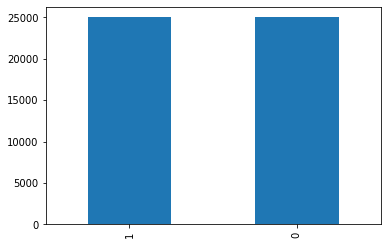

In [ ]:
# DONE: See Visualize class distribution (balanced or not). i.e use matplotlib or plotly
# import matplotlib.pyplot as plt

print(movie_reviews["review"][3],'\n')
print(movie_reviews.sentiment.value_counts(),'\n')

movie_reviews.sentiment.value_counts().plot(kind='bar')

### Data Preprocessing

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords

from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, Conv1D, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

In [ ]:
def preprocess_text(sen):
  # Removing tags
  sentence = remove_tags(sen)

  # Remove punctuations and numbers
  sentence = re.sub('[^a-zA-Z]', ' ', sentence)

  # Single character removal
  sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

  # Removing multiple spaces
  sentence = re.sub(r'\s+', ' ', sentence)

  return sentence

TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
  return TAG_RE.sub('', text)

In [ ]:
# Clean the data
X = []
sentences = list(movie_reviews['review'])
for sen in sentences:
  X.append(preprocess_text(sen))

#Split the data to train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, movie_reviews['sentiment'].values, test_size=0.20, random_state=42)

#Tokenize the data
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
X_train[1].T #vector of word representations 

array([  70, 1688,    2,  608,   17,  226,   58,   72,   48,   17,   72,
        928,   32,  364,    3,  475,  588,    1,  362,    2,  283,    1,
         12,  171,   96,  191,   53,   27,   84,   10, 1091,   89,  651,
        521,   39,   83,   69,  425,    8,   12,   48,   10,  537,    2,
       3808,  146, 1118,    1,  546,  288,   11,   77,   11, 1955,    1,
        110,    5,  179,   70,    1,  765,    5,  179,   70,    1,  608,
       1163,  154, 1492,   15,    1,  352,   66,  128,  179,  410,  135,
       2049,   51,   55,  151,    1,   12,  546,   42, 1183,   13,   64,
        128,   97,    6,  271,  393,   13,    1,   45,  156,  206,   17,
        115], dtype=int32)

In [ ]:
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [ ]:
X_train[1] #vector of word representations

array([  70, 1688,    2,  608,   17,  226,   58,   72,   48,   17,   72,
        928,   32,  364,    3,  475,  588,    1,  362,    2,  283,    1,
         12,  171,   96,  191,   53,   27,   84,   10, 1091,   89,  651,
        521,   39,   83,   69,  425,    8,   12,   48,   10,  537,    2,
       3808,  146, 1118,    1,  546,  288,   11,   77,   11, 1955,    1,
        110,    5,  179,   70,    1,  765,    5,  179,   70,    1,  608,
       1163,  154, 1492,   15,    1,  352,   66,  128,  179,  410,  135,
       2049,   51,   55,  151,    1,   12,  546,   42, 1183,   13,   64,
        128,   97,    6,  271,  393,   13,    1,   45,  156,  206,   17,
        115], dtype=int32)

### Get pre-trained embeddings (Glove)

In [ ]:
# DONE : Download Glove embeddings from http://nlp.stanford.edu/data/glove.6B.zip and unzip.
import requests 

#function copied from: https://stackoverflow.com/questions/9419162/download-returned-zip-file-from-url/51292933
def download_url(url, save_path, chunk_size=128):
    r = requests.get(url, stream=True)
    with open(save_path, 'wb') as fd:
        for chunk in r.iter_content(chunk_size=chunk_size):
            fd.write(chunk)

path = "http://nlp.stanford.edu/data/glove.6B.zip"
save_path = 'save_path.zip'
download_url(path, save_path)

In [ ]:
from zipfile import ZipFile
with ZipFile(save_path, 'r') as zipObj:
  zipObj.extractall()

In [ ]:
# Retrieve the embeddings and embedding matrix 
embeddings_dictionary = dict()
glove_file = open('glove.6B.100d.txt', encoding="utf8")
for line in glove_file:
  records = line.split()
  word = records[0]
  vector_dimensions = np.asarray(records[1:], dtype='float32')
  embeddings_dictionary [word] = vector_dimensions
glove_file.close()

embedding_matrix = np.zeros((vocab_size, 100)) # each embedding is of size 100 (maxlen) (100 columns)
for word, index in tokenizer.word_index.items():
  embedding_vector = embeddings_dictionary.get(word)
  if embedding_vector is not None:
    embedding_matrix[index] = embedding_vector

In [ ]:
print(embedding_matrix.shape) #92303 words

(92303, 100)


### Simple Neural Network

In [ ]:
model = Sequential()

# Create, add Embedding layer and freeze it 
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

#Flatten the embedding output 
model.add(Flatten())
model.add(Dense(64, activation='sigmoid'))
model.add(Dense(32, activation='relu'))
model.add(Dense(8, activation='tanh'))
model.add(Dense(1, activation='sigmoid'))

#Specify the optimizer, loss function and metric 
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          9230300   
_________________________________________________________________
flatten (Flatten)            (None, 10000)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                640064    
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 264       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 9,872,717
Trainable params: 642,417
Non-trainable params: 9,230,300
________________________________________

In [ ]:
# Train the model by calling the fit method. Specify the batch size, number of epochs and validation (optional)
history = model.fit(X_train, y_train, batch_size=128, epochs=10, verbose=0, validation_split=0.2)

# Evaluate the model on test set
score = model.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

313/313 [==============================] - 1s 2ms/step - loss: 1.0359 - acc: 0.7142
Test Score: 1.0358617305755615
Test Accuracy: 0.7142000198364258


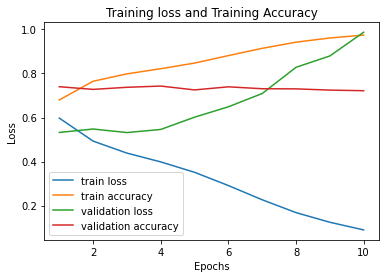

In [ ]:
# #DONE: Visualize the accuracy and loss of the model using i.e matplotlib.pyplot
import matplotlib.pyplot as plt

loss_train = history.history['loss']
acc_train = history.history['acc']

loss_val = history.history['val_loss']
acc_val = history.history['val_acc']

plt_epochs = range(1,11)

plt.plot(plt_epochs, loss_train)
plt.plot(plt_epochs, acc_train)
plt.plot(plt_epochs, loss_val)
plt.plot(plt_epochs, acc_val)

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training loss and Training Accuracy')
plt.legend(["train loss","train accuracy","validation loss","validation accuracy"], loc='best')
plt.show()

### Convolutional Neural Network

In [ ]:
model = Sequential()

embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          9230300   
_________________________________________________________________
conv1d (Conv1D)              (None, 96, 128)           64128     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 9,294,557
Trainable params: 64,257
Non-trainable params: 9,230,300
_________________________________________________________________
None


In [ ]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=0, validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

313/313 [==============================] - 1s 3ms/step - loss: 0.3587 - acc: 0.8419
Test Score: 0.35869643092155457
Test Accuracy: 0.8418999910354614


### Recurrent Neural Network (LSTM)

In [2]:
import torch
from torchtext.legacy import data
from torchtext.legacy import datasets
import random

SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
MAX_VOCAB_SIZE = 25_000

TEXT2 = data.Field(tokenize = 'spacy',
                  tokenizer_language = 'en_core_web_sm')#, include_lengths=True)
LABEL2 = data.LabelField(dtype = torch.float)

train_data2, test_data2 = datasets.IMDB.splits(TEXT2, LABEL2)
train_data2, valid_data2 = train_data2.split(random_state = random.seed(SEED))


TEXT2.build_vocab(train_data2, 
                 max_size = MAX_VOCAB_SIZE, 
                 vectors = "glove.6B.100d")
LABEL2.build_vocab(train_data2)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

BATCH_SIZE = 64
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data2, valid_data2, test_data2), 
    batch_size = BATCH_SIZE,
    device = device)

downloading aclImdb_v1.tar.gz


aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:07<00:00, 11.1MB/s]
.vector_cache/glove.6B.zip: 862MB [02:43, 5.27MB/s]                           
100%|█████████▉| 398074/400000 [00:22<00:00, 18162.28it/s]

In [1]:
# 1. Make improvements of the current RNN

import torch.nn as nn

class LSTM(nn.Module):
  #input_dim: dim of one hot encoding
  #hidden_dim: output of RNN (1-1, m-1, m-m)
  def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
    super().__init__()
    
    self.embedding_layer = nn.Embedding(input_dim, embedding_dim) #put one-hot input in encoder to get embedding
    self.lstm = nn.LSTM(embedding_dim, hidden_dim) #get rnn
    self.fc_layer = nn.Linear(hidden_dim, output_dim) #get output
      
  def forward(self, text):#, text_lengths):
    """
    Foward pass
    Args:
        text: (movie review, represented as one-hot-encoding)
            sentiment text with shape [sentence length, batch size]
    """
    embedded = self.embedding_layer(text) # embedding_layer output shape  (sentence length, batch size, embedding dim]
    # packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.to('cpu')) #PACK sequence
    output, (hidden, cell) = self.lstm(embedded)
    # output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output) #UNPACK sequence
        
    return self.fc_layer(hidden.squeeze(0)) #output = vector of output_dim length.

In [3]:
input_dim = len(TEXT2.vocab) #input dimension is the dimension of the one-hot vectors
embedding_dim = 100
hidden_dim = 256 #size of the hidden states (a tensor)
output_dim = 1 # for the fully connected (one neuron at the end, we use sigmoid)

model2 = LSTM(input_dim, embedding_dim, hidden_dim, output_dim)

In [14]:
#replace initial weights with pretrained weights (embeddings)
pretrained_embeddings = TEXT2.vocab.vectors
model2.embedding_layer.weight.data.copy_(pretrained_embeddings)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       device='cuda:0')

In [15]:
def train(model, iterator, optimizer, criterion):
  
  epoch_loss = 0
  epoch_acc = 0
  
  model.train()
  
  for batch in iterator:

    optimizer.zero_grad()

    batch_texts = batch.text
    predictions = model(batch_texts).squeeze(1) #size [batch_size=64, 1]  => [batch_size=64]
    
    loss = criterion(predictions, batch.label)

    acc = accuracy_calculator(predictions, batch.label)
    
    loss.backward()
    optimizer.step()
    
    epoch_loss += loss.item()
    epoch_acc += acc.item()
      
  return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [16]:
import torch.optim as optim
# define loss function and optimizer
optimizer = optim.Adam(model2.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()

#make model instance and send it to training device
model2 = model2.to(device)
criterion = criterion.to(device)

epochs = 5

best_valid_loss = float('inf')

for epoch in range(epochs):
  train_loss, train_acc = train(model2, train_iterator, optimizer, criterion)
  valid_loss, valid_acc = evaluate_model(model2, valid_iterator, criterion)
  
  if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    torch.save(model2.state_dict(), 'best-model-lstm.pt')
    
    print(f'Epoch: {epoch+1} , Train [Loss:  {train_loss:.3f}  Acc :{train_acc*100:.2f}], Val.[Loss: {valid_loss:.3f} Acc: {valid_acc*100:.2f}]')

Epoch: 1 , Train [Loss:  0.694  Acc :49.98], Val.[Loss: 0.693 Acc: 49.42]
Epoch: 3 , Train [Loss:  0.694  Acc :50.24], Val.[Loss: 0.693 Acc: 50.49]


In [24]:
# 2. Calculate number of model parameters (traninable and non-trainable)
trainables = sum(p.numel() for p in model2.parameters() if p.requires_grad)
print("Number of trainable parameters:", trainables)

nontrainables = sum(p.numel() for p in model2.parameters() if not p.requires_grad)
print("Number of non-trainable parameters:", nontrainables)

Number of trainable parameters: 2867049
Number of non-trainable parameters: 0


In [ ]:
#Method #2: Keras
#lab 4: "lstm then try gru then try rnn" Gcniziwe
model2k = Sequential()


In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# 3. Implement a method that will take a string (review sentence) and return a sentiment of that string
from collections import Counter

def sentence_sentiment(string, threshold):
  sentence = preprocess_text(string)
  sentence = [sentence]
  sentence = tokenizer.texts_to_sequences(sentence) #[[int],[int]...]
  sentence = pad_sequences(sentence, padding='post', maxlen=maxlen)
  
  sentiment = model.predict(sentence)

  return "pos" if (sentiment >= threshold) else "neg"


sentences = movie_reviews['review']
sentiments = movie_reviews['sentiment']
threshold = 0.5

for i, sen in enumerate(sentences):
  if(i<5):
    result = sentence_sentiment(sen, threshold)
    print("sentiment", result)
    print("expected:", sentiments[i], '\n')


sentiment pos
expected: 1 

sentiment neg
expected: 0 

sentiment neg
expected: 0 

sentiment pos
expected: 1 

sentiment pos
expected: 0 



## Lab Task
```
1. Make improvements of the current RNN by : 
  - Usin pre-trained word embeddings (GloVe)
  - different RNN architecture
  - multi-layer RNN or LSTM
  - a different optimizer
2. Calculate number of model parameters (traninable and non-trainable)
3. Implement a method that will take a string (review sentence) and return a sentiment of that string

**Try to get accuracy > 80%
```

<b>Note: </b> [GloVe: Global Vectors for Word Representation](https://nlp.stanford.edu/projects/glove/) <br>
<center>Don't to forget to make a Git commit</center>